# Отбор коров

# Описание проекта

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.

## Загрузка данных

Импортируем все необходимые для работы модули и выгрузим данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error
)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import( 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    precision_recall_curve
)

In [4]:
ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep = ';', decimal = ',')
ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep = ';', decimal = ',')
cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep = ';', decimal = ',')

Выведем первые 5 строчек из каждого датасета.

In [5]:
display(ferma_main.head())
display(ferma_dad.head())
display(cow_buy.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Выведем информацию о полученных датафреймах.

In [6]:
print(ferma_main.info())
print(ferma_dad.info())
print(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

##  Предобработка данных

In [7]:
display(ferma_main.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


Посмотрим на пропуски: где они и сколько их.

In [8]:
print(ferma_main.isna().sum())
print(ferma_dad.isna().sum())
print(cow_buy.isna().sum())

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64
id          0
Имя Папы    0
dtype: int64
Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64


Явных пропусков нет ни в одном из датафреймов. Проверим на наличие явных дубликатов.

In [9]:
print(ferma_main.duplicated().sum())
print(ferma_dad.duplicated().sum())
print(cow_buy.duplicated().sum())

5
0
4


Удалим явные дубликаты там, где они есть.

In [10]:
ferma_main = ferma_main.drop_duplicates()

Разберемся с типами данных. Исправим некоторые по необходимости.

In [11]:
ferma_main['Порода'] = ferma_main['Порода'].astype('category')
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].astype('category')
ferma_main['порода папы_быка'] = ferma_main['порода папы_быка'].astype('category')
ferma_main['Вкус молока'] = ferma_main['Вкус молока'].astype('category')
ferma_main['Возраст'] = ferma_main['Возраст'].astype('category')

print(ferma_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     629 non-null    int64   
 1   Удой, кг                               629 non-null    int64   
 2   ЭКЕ (Энергетическая кормовая единица)  629 non-null    float64 
 3   Сырой протеин, г                       629 non-null    int64   
 4   СПО (Сахаро-протеиновое соотношение)   629 non-null    float64 
 5   Порода                                 629 non-null    category
 6   Тип пастбища                           629 non-null    category
 7   порода папы_быка                       629 non-null    category
 8   Жирность,%                             629 non-null    float64 
 9   Белок,%                                629 non-null    float64 
 10  Вкус молока                            629 non-null    categor

С ЭКЕ явно что-то не так. Видимо, ошибка порядком: то 142, то 14. После поиска в интернете убеждаемся, что этот показатель должен быть в диапозоне порядком меньше. Аналогично и с почти всеми остальными числовами данными.

In [12]:
print(ferma_main.describe())

              id      Удой, кг  ЭКЕ (Энергетическая кормовая единица)  \
count  629.00000    629.000000                             629.000000   
mean   315.00000   6188.750397                              14.543879   
std    181.72094   1644.795489                               1.306408   
min      1.00000   5204.000000                              10.900000   
25%    158.00000   5751.000000                              13.500000   
50%    315.00000   6133.000000                              14.700000   
75%    472.00000   6501.000000                              15.600000   
max    629.00000  45616.000000                              16.800000   

       Сырой протеин, г  СПО (Сахаро-протеиновое соотношение)  Жирность,%  \
count        629.000000                            629.000000  629.000000   
mean        1923.364070                              0.913116    3.603657   
std          182.956251                              0.032203    0.168656   
min         1660.000000           

In [13]:
display(ferma_main)

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


Аналогично поступим с датафреймом cow_buy.

In [14]:
display(cow_buy)
print(cow_buy.info())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB
None


## Исследовательский анализ данных

Проведем статистический анализ всех признаков.

In [15]:
display(ferma_main.describe())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


С удоем что-то интересное: 45616 кг? Похоже на ошибку в данных. Посмотрим этот столбец на наличие выбросов:

In [16]:
print(ferma_main['Удой, кг'].sort_values(ascending = False).head())

16     45616
70      7222
135     7207
296     7201
294     7197
Name: Удой, кг, dtype: int64


Ну да, 45616 кг - явная ошибка. Можно строку с этим значением удалить.

In [17]:
ferma_main = ferma_main[ferma_main['Удой, кг'] < 10000]

In [18]:
print(cow_buy.describe())

       Текущая_жирность,%  Текущий_уровень_белок,%
count           20.000000                20.000000
mean             3.577500                 3.069500
std              0.126818                 0.010339
min              3.340000                 3.046000
25%              3.510000                 3.064000
50%              3.590000                 3.074000
75%              3.650000                 3.076000
max              3.770000                 3.081000


Построим графики для всех количественных признаков. Cначала - для ferma_main.

Text(0, 0.5, 'количество коров')

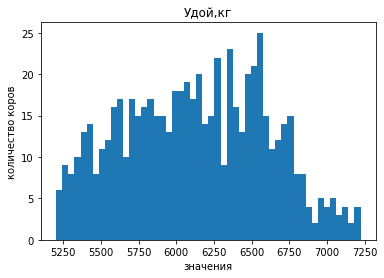

In [19]:
plt.hist(ferma_main['Удой, кг'], bins = 50)
plt.title('Удой,кг')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

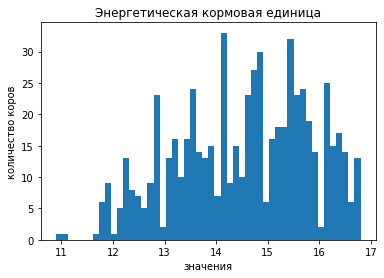

In [20]:
plt.hist(ferma_main['ЭКЕ (Энергетическая кормовая единица)'], bins = 50)
plt.title('Энергетическая кормовая единица')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

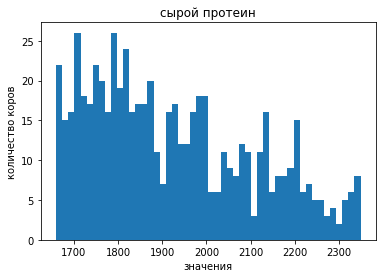

In [21]:
plt.hist(ferma_main['Сырой протеин, г'], bins = 50)
plt.title('сырой протеин')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

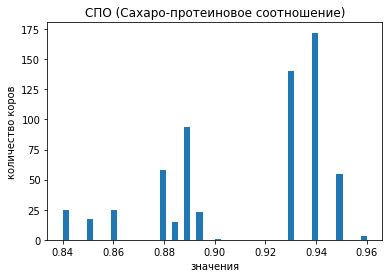

In [22]:
plt.hist(ferma_main['СПО (Сахаро-протеиновое соотношение)'], bins = 50)
plt.title('СПО (Сахаро-протеиновое соотношение)')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

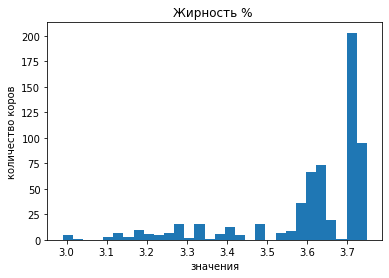

In [23]:
plt.hist(ferma_main['Жирность,%'], bins = 30)
plt.title('Жирность % ')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

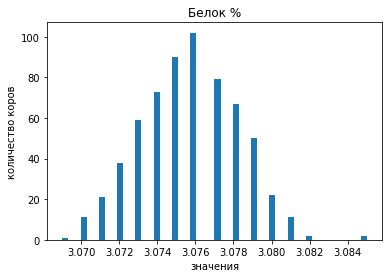

In [24]:
plt.hist(ferma_main['Белок,%'], bins = 50)
plt.title('Белок %')
plt.xlabel('значения')
plt.ylabel('количество коров')

Теперь категориальные признаки ferma_main:

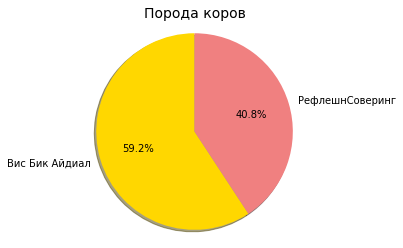

In [25]:
ferma_main['Порода'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral']  # Цвета
)

# 2. Настройка отображения
plt.title('Порода коров', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

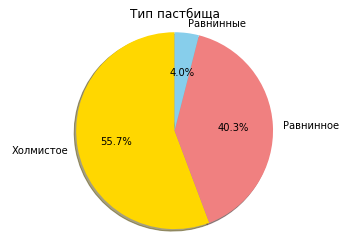

In [26]:
ferma_main['Тип пастбища'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle=90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral', 'skyblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Тип пастбища', fontsize=12)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()


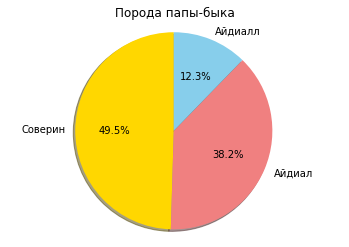

In [27]:
ferma_main['порода папы_быка'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle=90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral', 'skyblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Порода папы-быка', fontsize=12)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

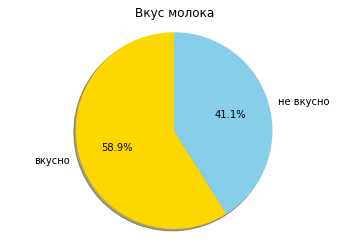

In [28]:
ferma_main['Вкус молока'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle=90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'skyblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Вкус молока', fontsize=12)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

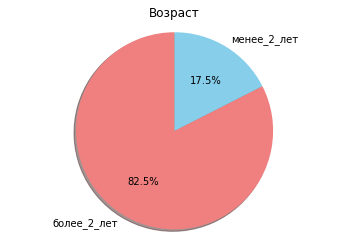

In [29]:
ferma_main['Возраст'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle=90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['lightcoral', 'skyblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Возраст', fontsize=12)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

Теперь датафрейм ferma_dad. Там содержатся только имена быков-отцов. Это категориальный признак и там всего 4 имени (см. ниже)

In [30]:
print(ferma_dad['Имя Папы'].value_counts())

Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: Имя Папы, dtype: int64


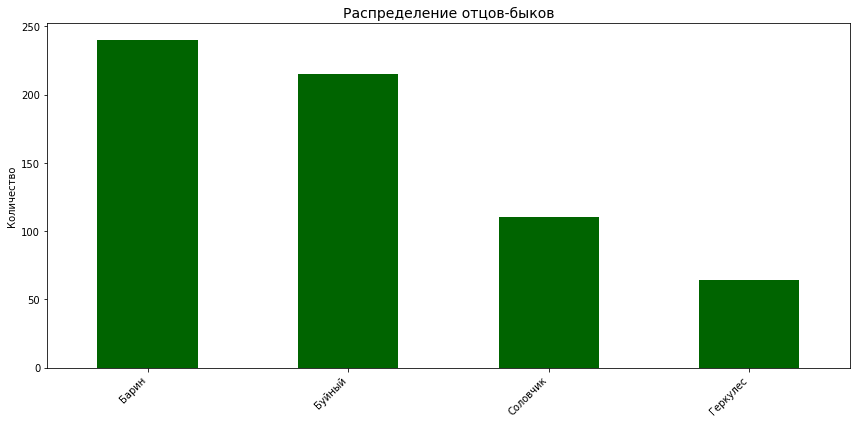

In [31]:
counts = ferma_dad['Имя Папы'].value_counts()
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='darkgreen')

plt.title('Распределение отцов-быков', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.ylabel('Количество')
plt.tight_layout()

Теперь датафрейм cow_buy. У него два количественных признака и пять количественных.

In [32]:
display(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


Text(0, 0.5, 'количество коров')

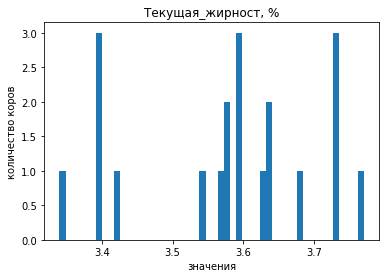

In [33]:
plt.hist(cow_buy['Текущая_жирность,%'], bins = 50)
plt.title('Текущая_жирност, %')
plt.xlabel('значения')
plt.ylabel('количество коров')

Text(0, 0.5, 'количество коров')

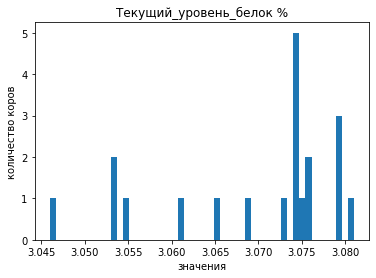

In [34]:
plt.hist(cow_buy['Текущий_уровень_белок,%'], bins = 50)
plt.title('Текущий_уровень_белок %')
plt.xlabel('значения')
plt.ylabel('количество коров')

Теперь категориальные признаки.

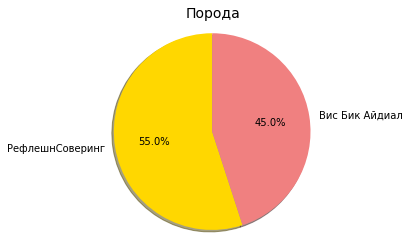

In [35]:
cow_buy['Порода'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral']  # Цвета
)

# 2. Настройка отображения
plt.title('Порода', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

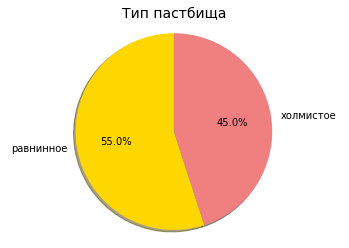

In [36]:
cow_buy['Тип пастбища'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral','green']  # Цвета
)

# 2. Настройка отображения
plt.title('Тип пастбища', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

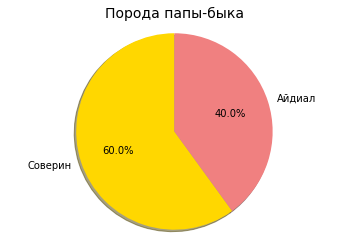

In [37]:
cow_buy['порода папы_быка'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral','green']  # Цвета
)

# 2. Настройка отображения
plt.title('Порода папы-быка', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

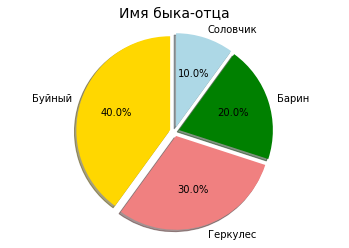

In [38]:
cow_buy['Имя_папы'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    explode=(0.05,)*4,    # Разделение сегментов (кортеж с отступами)
    colors=['gold', 'lightcoral','green','lightblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Имя быка-отца', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

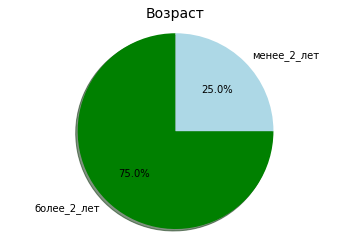

In [39]:
cow_buy['Возраст'].value_counts().plot.pie(
    autopct='%1.1f%%',   # Формат процентов
    shadow=True,          # Тень
    startangle = 90,        # Начальный угол (90° = сверху)
    #explode=(0.05,)*3,    # Разделение сегментов (кортеж с отступами)
    colors=['green','lightblue']  # Цвета
)

# 2. Настройка отображения
plt.title('Возраст', fontsize=14)
plt.ylabel('')  # Скрываем метку оси Y
plt.axis('equal')  # Круг вместо эллипса
plt.show()

Вывод. По поводу датафрейма ferma_main. Начнем с количественных показателей. Распределение удоя отдаленно напоминает нормальное, но много скачков. ЭКЕ - больше показаний от 14 до 16. Сырой протеин - от 1700 до 2000г, далее - существенно меньше. СПО - больше всего значений 0.93 и 0.94. У жирности самый распространенный показатель - около 3.7. Есть еще 3.6, остальные же почти не встречаются. Распределение белка очень похоже на нормальное, самый частый показатель - 3.076%. Насчет категориальных данных: мало равнинных пастбищ (4%), большая часть коров старше 2 лет (82.5%). В датафрейме ferma_dad мы обнаруживаем, что быков-отцов всего 4; больше всего детей у Барина и Буйного (455 из 629 или 72.4%). В датафрейме cow_buy ситуация следующая. По жирности два самых распространенных показателя 3.4% и 3.73%. По белку самое частое значение - 3.8%. Породы и пастбища распределены поровну, с быками-отцами ситуация чуть сложнее. Как и в ferma_main здесь преобладают коровы, которым больше двух лет. 

Ну а вообще, по cow_buy трудно делать выводы, ибо строк в этом датафрейме всего 16.

Чтобы улучшить данные в ferma_main, нужно рассматривать связи одни признаков с другими и считать статистики уже исходя из этого. Этим и займёмся далее. 

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между всеми признаками в ferma_main.

In [40]:
ferma_main.corr(method='spearman')

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),"Жирность,%","Белок,%"
id,1.000000,-0.003097,-0.022382,-0.037108,-0.021642,0.038631,0.003743
"Удой, кг",-0.003097,1.000000,0.765144,0.437543,0.787904,0.688506,-0.005701
ЭКЕ (Энергетическая кормовая единица),-0.022382,0.765144,1.000000,0.384747,0.741962,0.686973,-0.013321
"Сырой протеин, г",-0.037108,0.437543,0.384747,1.000000,0.485890,0.392822,0.229051
СПО (Сахаро-протеиновое соотношение),-0.021642,0.787904,0.741962,0.485890,1.000000,0.701044,0.109924
"Жирность,%",0.038631,0.688506,0.686973,0.392822,0.701044,1.000000,0.043125
"Белок,%",0.003743,-0.005701,-0.013321,0.229051,0.109924,0.043125,1.000000


Достаточно сильные связи:

1) между удоем и ЭКЕ (0.76)

2) между СПО и удоем (0.8)

3) между удоем и жирностью (слабее, 0.6)

4) между СПО и ЭКЕ (0.75)

5) между жирностью и ЭКЕ (0.63)

Получается, что удой весьма сильно влияет аж на три показателя!

Теперь построим диаграммы scatterplot для признака 'удой' и всех количественных признаков с учетом категориальных.

Text(0.5, 1.0, 'Связь удоя и ЭКЕ')

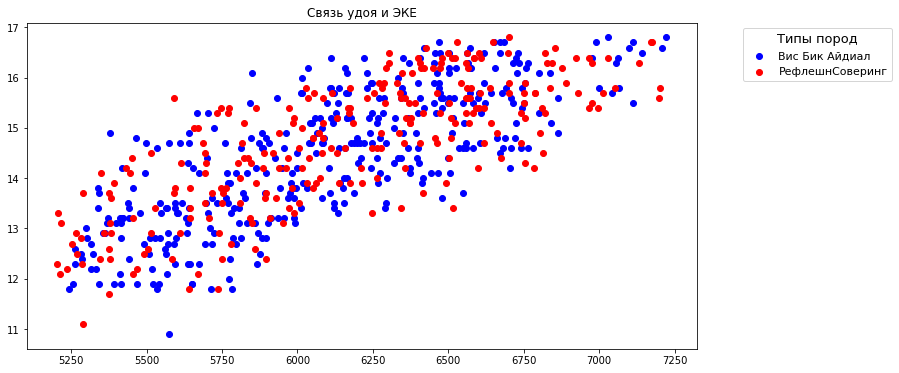

In [41]:
colors =['blue','red']
plt.figure(figsize = (12,6))
categories = ferma_main['Порода'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Порода'] == category]
    plt.scatter(subset['Удой, кг'], subset['ЭКЕ (Энергетическая кормовая единица)'], label = category, c = [color])

    
plt.legend(
    title='Типы пород',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1) 
)
plt.title('Связь удоя и ЭКЕ')

Text(0.5, 1.0, 'Связь удоя и ЭКЕ')

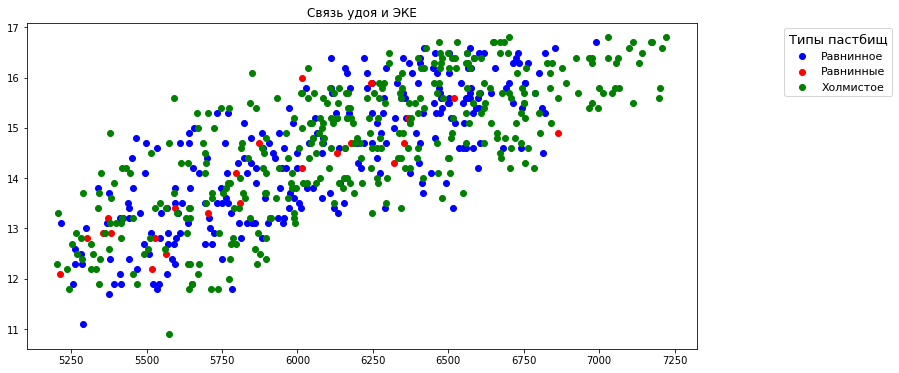

In [42]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Тип пастбища'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Тип пастбища'] == category]
    plt.scatter(subset['Удой, кг'], subset['ЭКЕ (Энергетическая кормовая единица)'], label = category, c = [color])

    
plt.legend(
    title='Типы пастбищ',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и ЭКЕ')

Text(0.5, 1.0, 'Связь удоя и ЭКЕ')

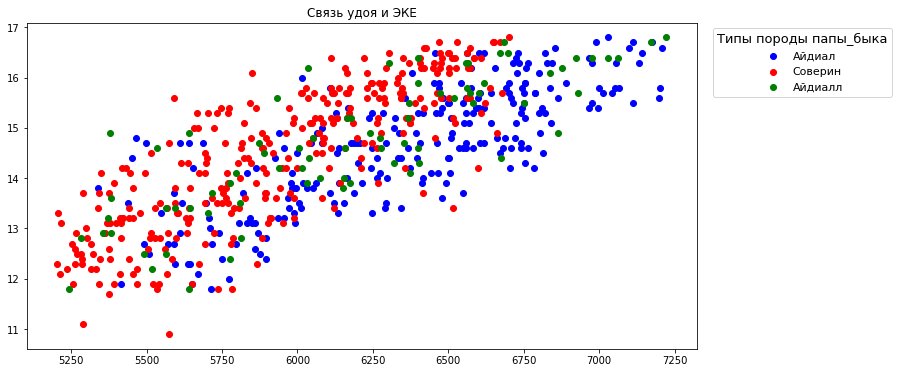

In [43]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['порода папы_быка'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['порода папы_быка'] == category]
    plt.scatter(subset['Удой, кг'], subset['ЭКЕ (Энергетическая кормовая единица)'], label = category, c = [color])
    
    
plt.legend(
    title='Типы породы папы_быка',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1) 
)
plt.title('Связь удоя и ЭКЕ')

Вот тут есть что-то интересное. Коровы, у которых отец породы 'Соверин' в целом дают меньше молока, чем другие коровы.

Text(0.5, 1.0, 'Связь удоя и ЭКЕ')

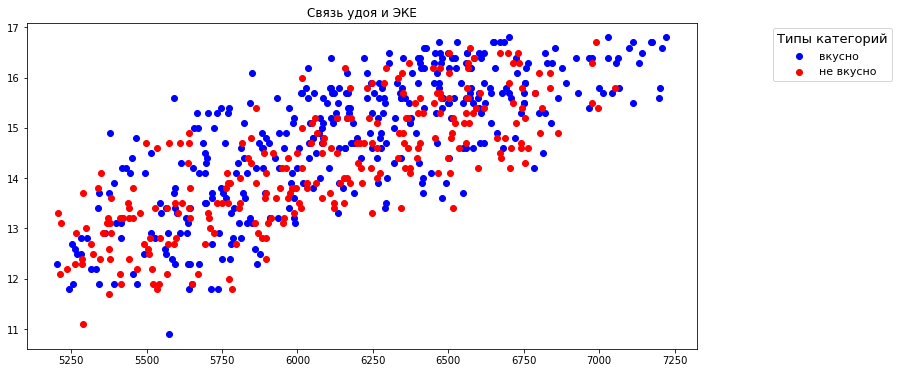

In [44]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Вкус молока'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Вкус молока'] == category]
    plt.scatter(subset['Удой, кг'], subset['ЭКЕ (Энергетическая кормовая единица)'], label = category, c = [color])
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и ЭКЕ')

Text(0.5, 1.0, 'Связь удоя и ЭКЕ')

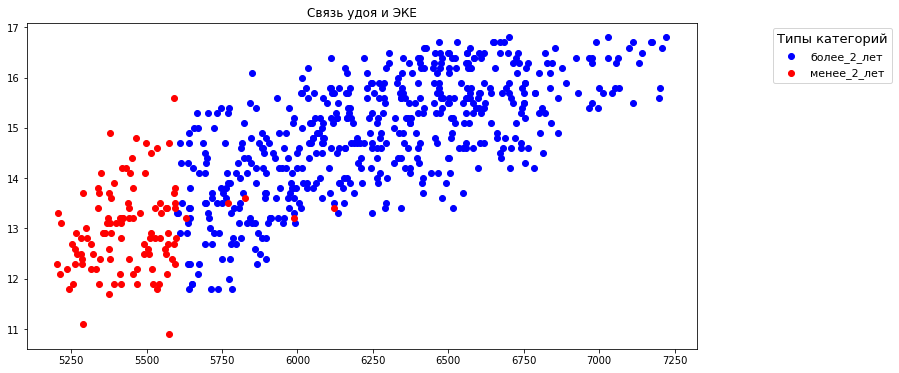

In [45]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Возраст'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Возраст'] == category]
    plt.scatter(subset['Удой, кг'], subset['ЭКЕ (Энергетическая кормовая единица)'], label = category, c = [color])
    
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и ЭКЕ')

Невооруженным взглядом видно, что более юные коровы дают меньше молока и у него меньше ЭКЕ.

Text(0.5, 1.0, 'Связь удоя и количества сырого протеина')

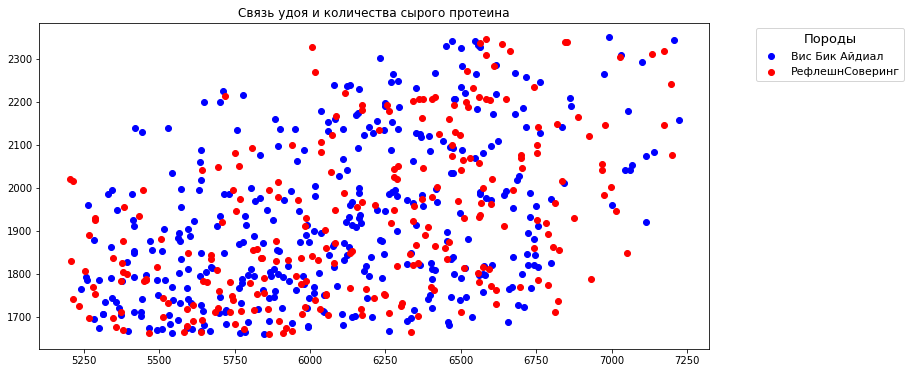

In [46]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Порода'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Порода'] == category]
    plt.scatter(subset['Удой, кг'], subset['Сырой протеин, г'], label = category, c = [color])
    
       
plt.legend(
    title='Породы',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и количества сырого протеина')

Text(0.5, 1.0, 'Связь удоя и количества сырого протеина')

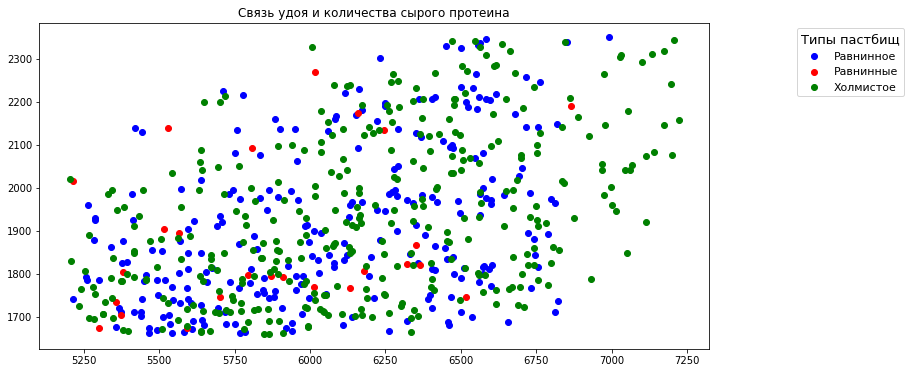

In [47]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Тип пастбища'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Тип пастбища'] == category]
    plt.scatter(subset['Удой, кг'], subset['Сырой протеин, г'], label = category, c = [color])
    
    
plt.legend(
    title='Типы пастбищ',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и количества сырого протеина')

Text(0.5, 1.0, 'Связь удоя и количества сырого протеина')

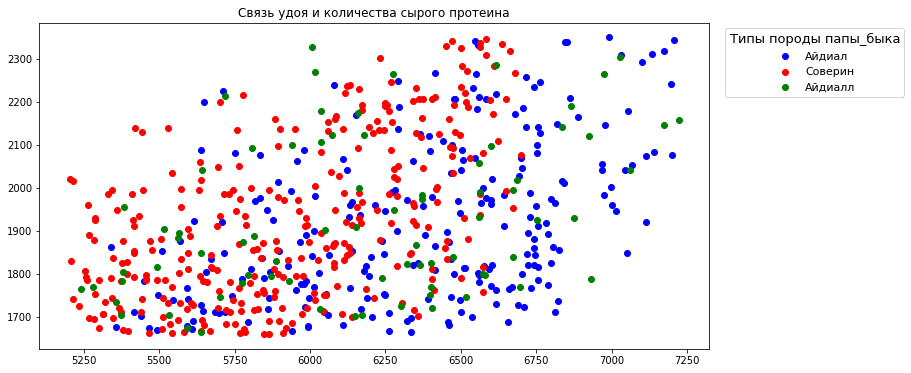

In [48]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['порода папы_быка'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['порода папы_быка'] == category]
    plt.scatter(subset['Удой, кг'], subset['Сырой протеин, г'], label = category, c = [color])
    
    
plt.legend(
    title='Типы породы папы_быка',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и количества сырого протеина')

Text(0.5, 1.0, 'Связь удоя и количества сырого протеина')

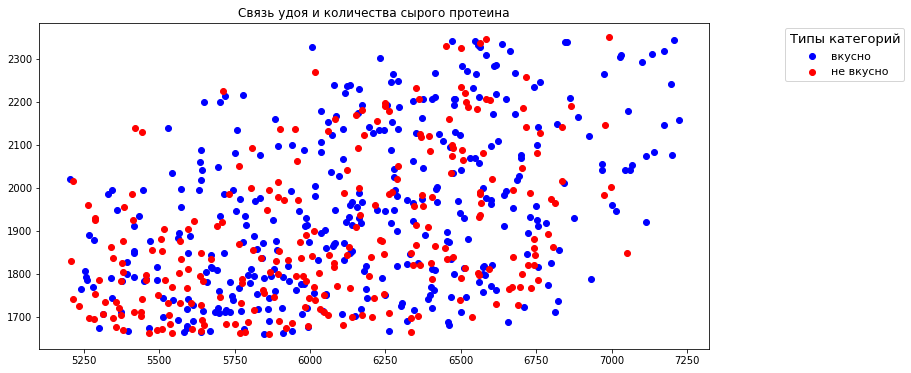

In [49]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Вкус молока'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Вкус молока'] == category]
    plt.scatter(subset['Удой, кг'], subset['Сырой протеин, г'], label = category, c = [color])
    
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и количества сырого протеина')

Text(0.5, 1.0, 'Связь удоя и количества сырого протеина')

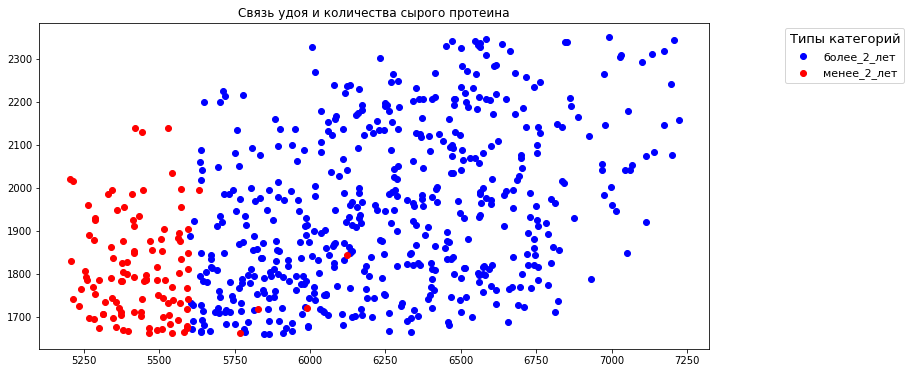

In [50]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Возраст'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Возраст'] == category]
    plt.scatter(subset['Удой, кг'], subset['Сырой протеин, г'], label = category, c = [color])
    
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и количества сырого протеина')

Text(0.5, 1.0, 'Связь удоя и СПО')

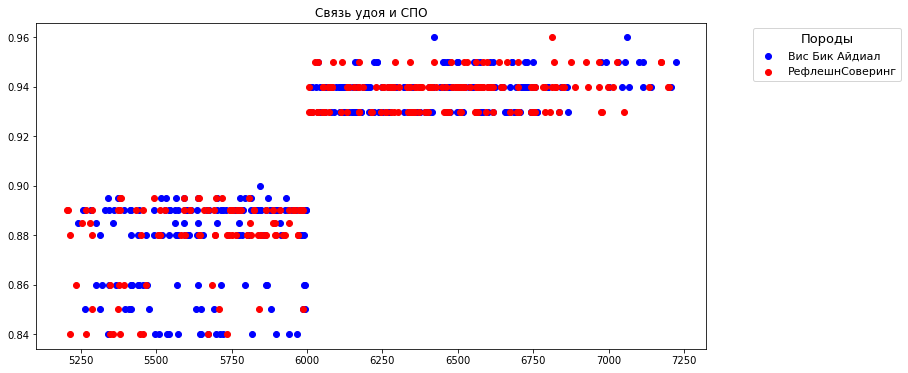

In [51]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Порода'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Порода'] == category]
    plt.scatter(subset['Удой, кг'], subset['СПО (Сахаро-протеиновое соотношение)'], label = category, c = [color])
    
    
    
plt.legend(
    title='Породы',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1) 
)
plt.title('Связь удоя и СПО')

Чем больше удой, тем больше сахарно - протеиновое отношение. Во-вторых, СПО больше у породы РефлешнСоверинг.

Text(0.5, 1.0, 'Связь удоя и СПО')

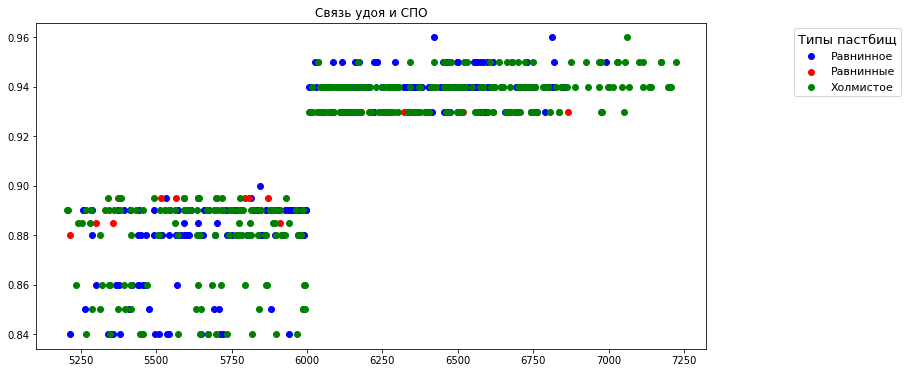

In [52]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Тип пастбища'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Тип пастбища'] == category]
    plt.scatter(subset['Удой, кг'], subset['СПО (Сахаро-протеиновое соотношение)'], label = category, c = [color])
    
    
plt.legend(
    title='Типы пастбищ',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и СПО')

Больше всего СПО у коров на холмистом пастбище.

Text(0.5, 1.0, 'Связь удоя и СПО')

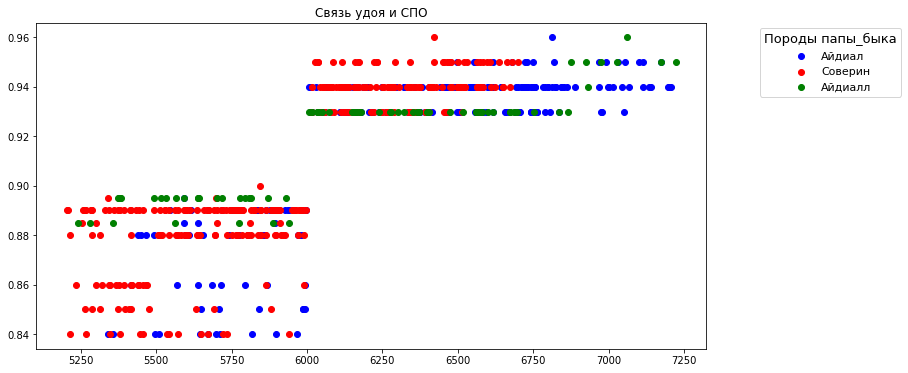

In [53]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['порода папы_быка'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['порода папы_быка'] == category]
    plt.scatter(subset['Удой, кг'], subset['СПО (Сахаро-протеиновое соотношение)'], label = category, c = [color])
    
    
plt.legend(
    title='Породы папы_быка',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и СПО')

Text(0.5, 1.0, 'Связь удоя и СПО')

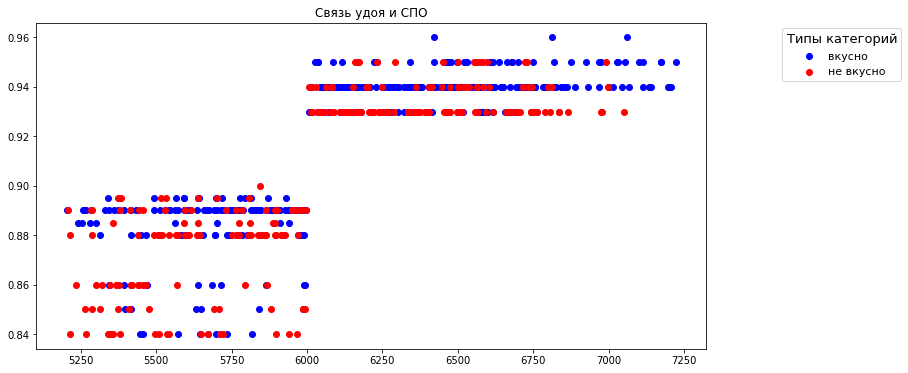

In [54]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Вкус молока'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Вкус молока'] == category]
    plt.scatter(subset['Удой, кг'], subset['СПО (Сахаро-протеиновое соотношение)'], label = category, c = [color])
    
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и СПО')

Text(0.5, 1.0, 'Связь удоя и СПО')

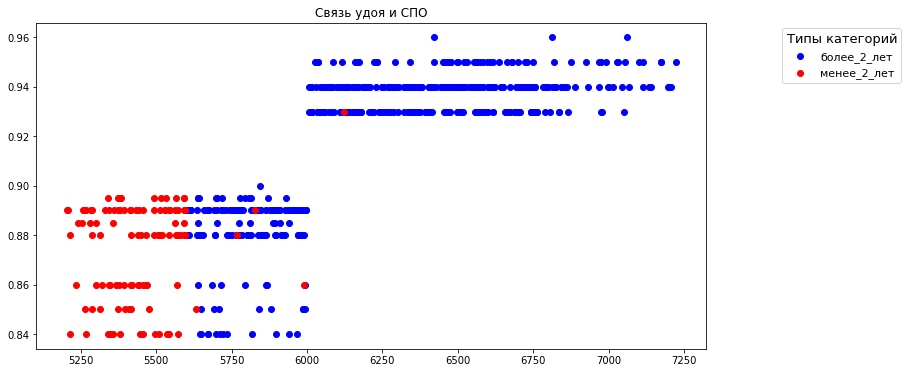

In [55]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Возраст'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Возраст'] == category]
    plt.scatter(subset['Удой, кг'], subset['СПО (Сахаро-протеиновое соотношение)'], label = category, c = [color])
    
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и СПО')

Text(0.5, 1.0, 'Связь удоя и жирности')

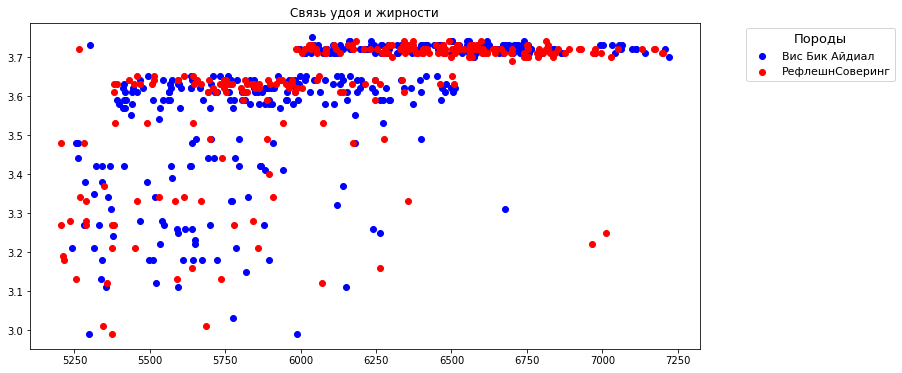

In [56]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Порода'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Порода'] == category]
    plt.scatter(subset['Удой, кг'], subset['Жирность,%'], label = category, c = [color])
    
    
plt.legend(
    title='Породы',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и жирности')

Text(0.5, 1.0, 'Связь удоя и жирности')

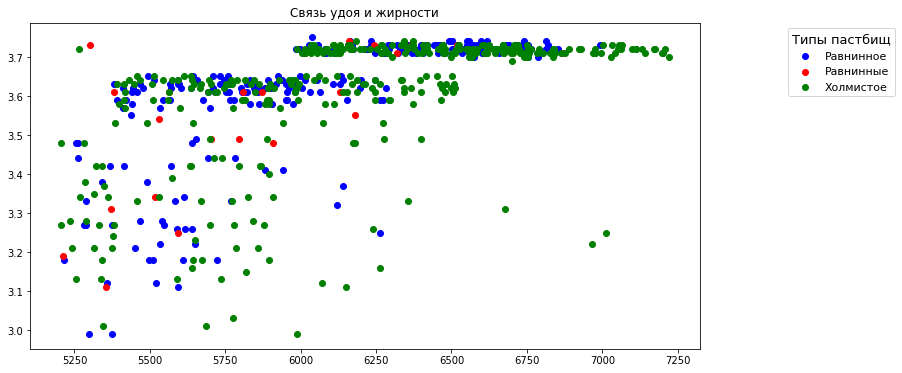

In [57]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Тип пастбища'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Тип пастбища'] == category]
    plt.scatter(subset['Удой, кг'], subset['Жирность,%'], label = category, c = [color])
    
    
plt.legend(
    title='Типы пастбищ',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и жирности')

Text(0.5, 1.0, 'Связь удоя и жирности')

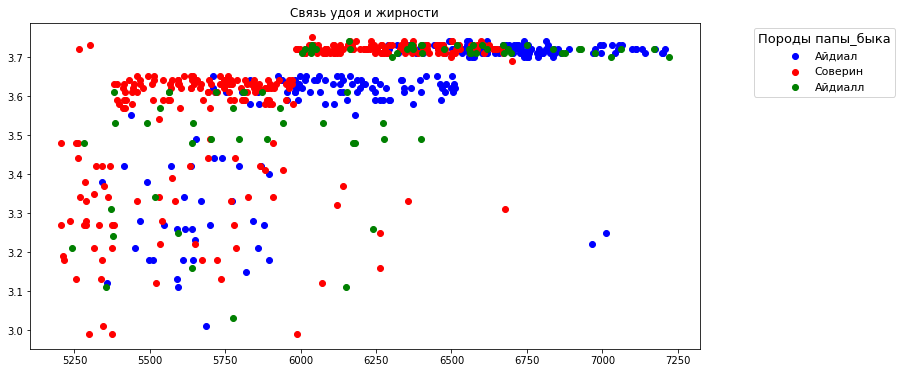

In [58]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['порода папы_быка'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['порода папы_быка'] == category]
    plt.scatter(subset['Удой, кг'], subset['Жирность,%'], label = category, c = [color])
    
    
plt.legend(
    title='Породы папы_быка',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и жирности')

Text(0.5, 1.0, 'Связь удоя и жирности')

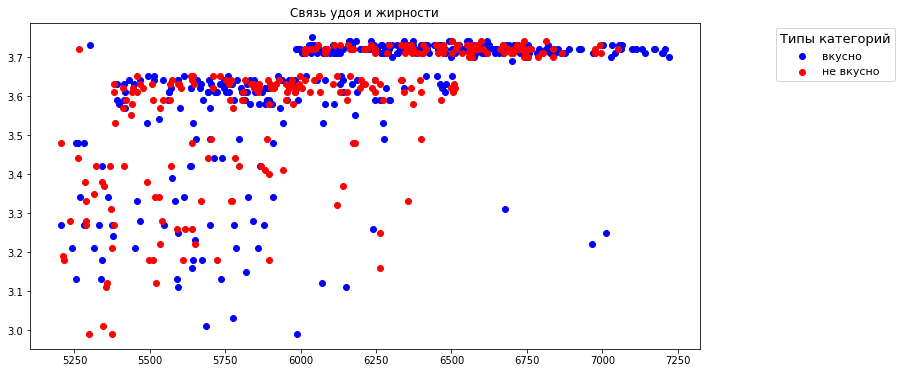

In [59]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Вкус молока'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Вкус молока'] == category]
    plt.scatter(subset['Удой, кг'], subset['Жирность,%'], label = category, c = [color])
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и жирности')

Text(0.5, 1.0, 'Связь удоя и жирности')

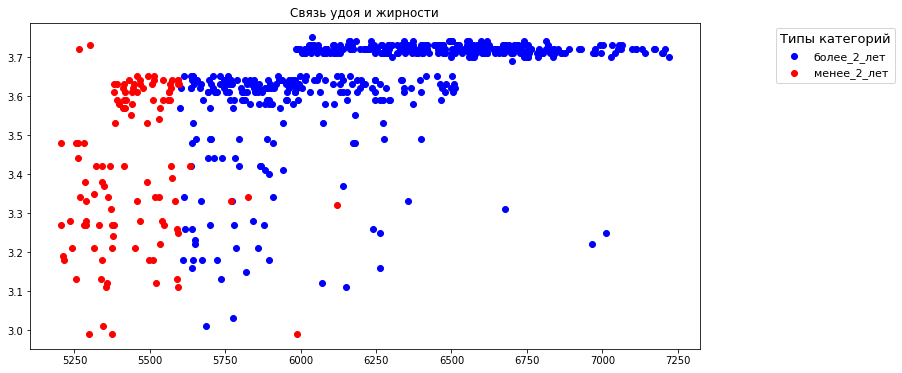

In [60]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Возраст'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Возраст'] == category]
    plt.scatter(subset['Удой, кг'], subset['Жирность,%'], label = category, c = [color])
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и жирности')

Text(0.5, 1.0, 'Связь удоя и белка')

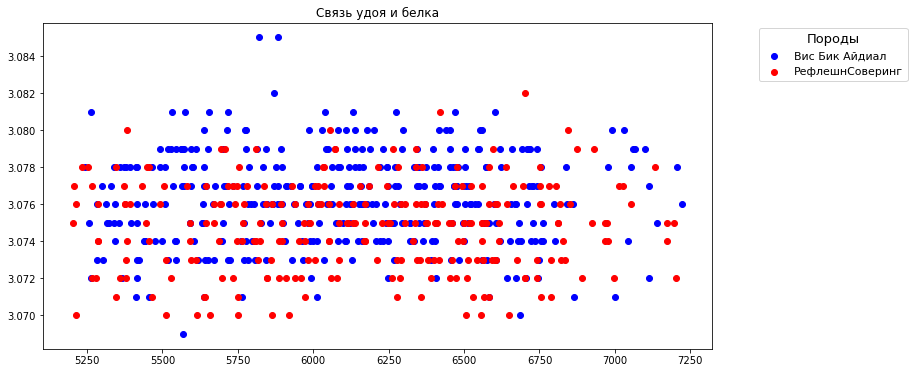

In [61]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Порода'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Порода'] == category]
    plt.scatter(subset['Удой, кг'], subset['Белок,%'], label = category, c = [color])
    
plt.legend(
    title='Породы',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)
)
plt.title('Связь удоя и белка')

Text(0.5, 1.0, 'Связь удоя и белка')

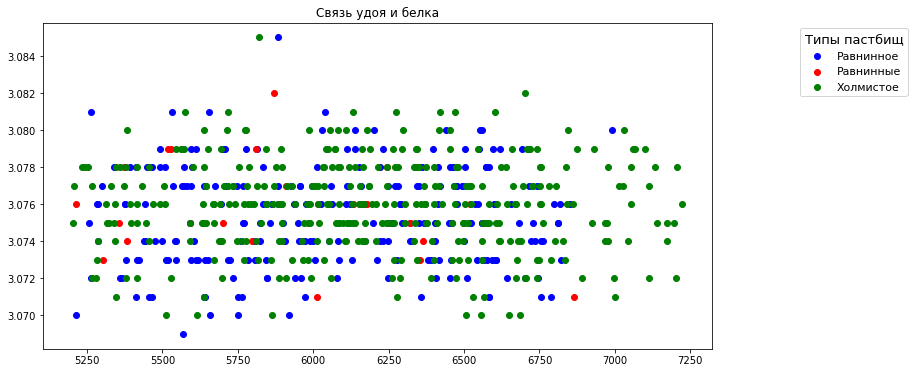

In [62]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Тип пастбища'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Тип пастбища'] == category]
    plt.scatter(subset['Удой, кг'], subset['Белок,%'], label = category, c = [color])
    
    
plt.legend(
    title='Типы пастбищ',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и белка')

Text(0.5, 1.0, 'Связь удоя и белка')

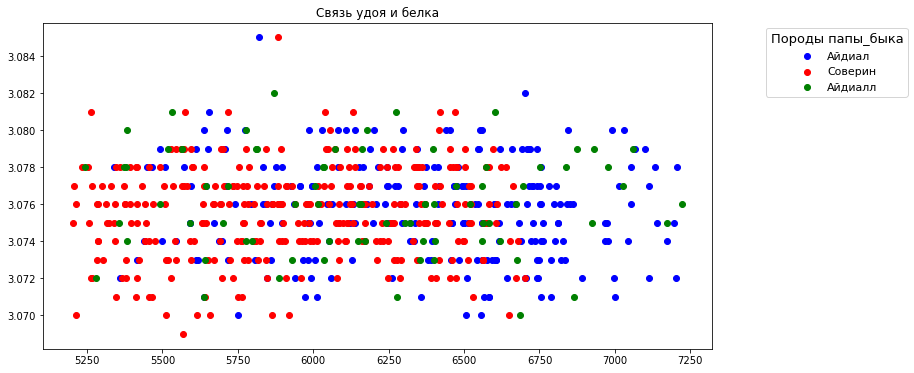

In [63]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['порода папы_быка'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['порода папы_быка'] == category]
    plt.scatter(subset['Удой, кг'], subset['Белок,%'], label = category, c = [color])
    
plt.legend(
    title='Породы папы_быка',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и белка')

Text(0.5, 1.0, 'Связь удоя и белка')

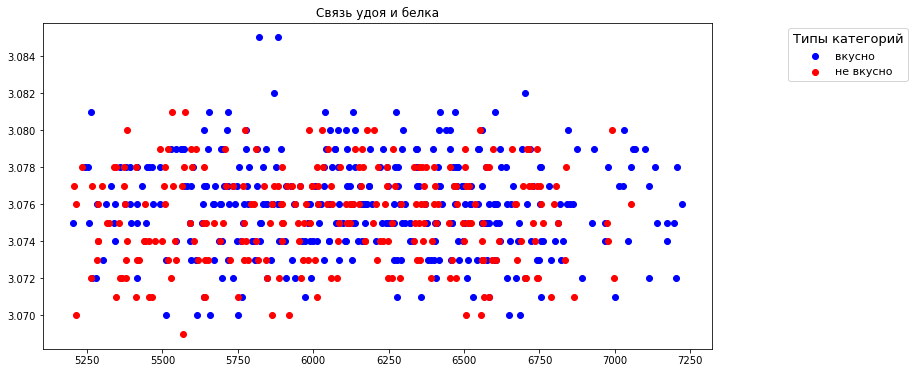

In [64]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Вкус молока'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Вкус молока'] == category]
    plt.scatter(subset['Удой, кг'], subset['Белок,%'], label = category, c = [color])
    
    plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1) 
)
plt.title('Связь удоя и белка')

Text(0.5, 1.0, 'Связь удоя и белка')

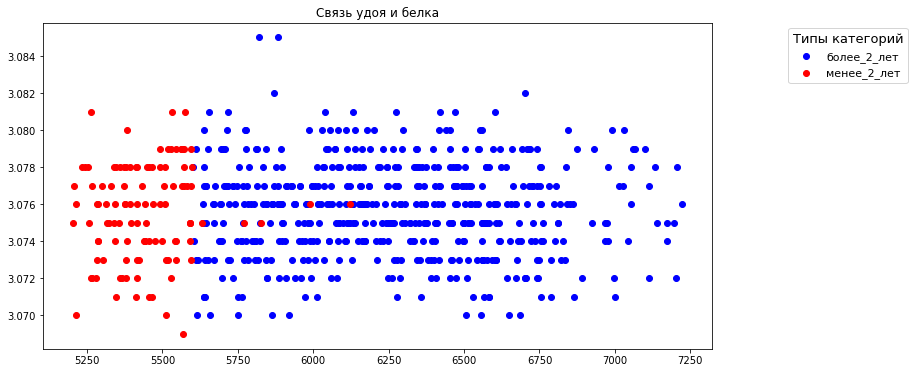

In [65]:
colors =['blue','red','green']
plt.figure(figsize = (12,6))
categories = ferma_main['Возраст'].unique()
for category,color in zip(categories, colors):
    subset = ferma_main[ferma_main['Возраст'] == category]
    plt.scatter(subset['Удой, кг'], subset['Белок,%'], label = category, c = [color])
    
plt.legend(
    title='Типы категорий',
    title_fontsize='13',
    fontsize=11,
    loc='upper right',
    bbox_to_anchor=(1.3, 1)  
)
plt.title('Связь удоя и белка')

Проанализируем связь удоя с остальными признаками.

эке: Наблюдается положительная взаимосвязь выше умеренного значения. С увеличением "удоя" постепенно увеличивается и эке. По графикам распределения, корреляция справедлива как для одной, так и для другой породы. Коэффициенты взаимосвязи: 0.76

сырой_протеин: Взаимосвязь между содержанием сырого протеина и удоем не так ясна. На графике диаграмме рассеяния виден довольно большой разброс значений, однако наблюдается общий тренд на прямую пропорциональную зависимость. Связь умеренно положительная. Коэффициенты взаимосвязи: 0.44

спо: Похоже, что СПО сильно зависит от целевого признака - высокий коэффициент корреляции. В особенности видна резкая тенденция возвышения значений после. Связь похожа не нелинейную, но есть спорный момент с переходом в значении спо == 0.91 

жирность: Умеренно положительная зависимость. Более всего связь раскрывается на переходе значений жирность == 3.6 и 3.7. Коэффициент взаимосвязи: 0.6

белок: Связь между этим признаком и целевым - нелинейная.

Между целевым и входными признаками связь в основном линейная, но наличие нелинейных связей также возможно для отдельных пород.

Нелинейная связь в итоге с белком, сырым протеином. С СПО кажется, что связь линейная, но на графике видно, что есть скачок. С ЭКЕ связь похожа на линейную, но не совсем. Мы будем возводить в квадрат эти показатели, чтобы сделать связь более линейной.

По мультиколлинеарности: корреляционная матрица показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности, с которой стоило бы справляться.

## Обучение модели линейной регрессии

# Первая модель

Сформируем датасет, с которым будем работать.

In [66]:
ferma_main_1 = ferma_main[['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Порода','Тип пастбища','порода папы_быка','Возраст','Удой, кг', 'Сырой протеин, г']]


In [67]:
X = ferma_main_1.drop(['Удой, кг'], axis = 1)
y = ferma_main_1['Удой, кг']

Разобьем датасет на тренировачную и тестовую выборки.

In [68]:
RANDOM_STATE = 4242
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = RANDOM_STATE)

Кодируем категориальные признаки.

In [69]:
X_train_cat = X_train[['Порода','Тип пастбища','порода папы_быка','Возраст']]
X_test_cat = X_test[['Порода','Тип пастбища','порода папы_быка','Возраст']]

X_train_num = X_train[['Сырой протеин, г','ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)']]
X_test_num = X_test[['Сырой протеин, г','ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)']]

 <div <div class="alert alert-block alert-info">>
  Белок и жирность я и так не использовал в обучении, хоть изначально и добавлял в тренировачный датасет. Вкус молока убрал
</div>

In [70]:
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(X_train_cat)

OneHotEncoder(drop='first', sparse=False)

In [71]:
X_train_cat = encoder.transform(X_train_cat)

In [72]:
X_test_cat = encoder.transform(X_test_cat)

In [73]:
encoder.get_feature_names() 

array(['x0_РефлешнСоверинг', 'x1_Равнинные', 'x1_Холмистое', 'x2_Айдиалл',
       'x2_Соверин', 'x3_менее_2_лет'], dtype=object)

Масштабируем количественные признаки.

In [74]:
scaler = StandardScaler()

In [75]:
scaler.fit(X_train_num)

StandardScaler()

In [76]:
X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

Приведём полученные результаты к виду DataFrame.

In [77]:
X_train_cat = pd.DataFrame(X_train_cat, columns = encoder.get_feature_names())
X_test_cat = pd.DataFrame(X_test_cat, columns = encoder.get_feature_names())

In [78]:
X_train_num = pd.DataFrame(X_train_num)
X_test_num = pd.DataFrame(X_test_num)

Склеим преобразованные количественные и категориальные данные в один DataFrame

In [79]:
X_train = pd.concat([X_train_num, X_train_cat],axis  = 1)
X_test = pd.concat([X_test_num, X_test_cat],axis  = 1)

Теперь займёмся обучением.

In [80]:
model_lr = LinearRegression()

In [81]:
model_lr.fit(X_train, y_train)

LinearRegression()

In [82]:
predictions = model_lr.predict(X_test)

Подсчитаем точность модели с помощью метрики R2

In [83]:
r2_score_1 = r2_score(y_test, predictions)

print(r2_score_1)

0.788931085319901


In [84]:
mse_1 = mean_squared_error(y_test, predictions)
rmse_1 = mean_squared_error(y_test, predictions, squared=False)
mae_1 = mean_absolute_error(y_test, predictions)

Проанализируем остатки.

(array([ 3.,  1.,  2.,  3.,  2.,  1.,  6.,  6., 10.,  9., 13., 12., 14.,
        14.,  8.,  5., 10.,  8.,  3.,  4.,  7.,  5.,  2.,  2.,  2.,  0.,
         1.,  2.,  1.,  1.]),
 array([-519.60930941, -482.33905199, -445.06879456, -407.79853714,
        -370.52827972, -333.25802229, -295.98776487, -258.71750745,
        -221.44725002, -184.1769926 , -146.90673518, -109.63647775,
         -72.36622033,  -35.0959629 ,    2.17429452,   39.44455194,
          76.71480937,  113.98506679,  151.25532421,  188.52558164,
         225.79583906,  263.06609648,  300.33635391,  337.60661133,
         374.87686876,  412.14712618,  449.4173836 ,  486.68764103,
         523.95789845,  561.22815587,  598.4984133 ]),
 <BarContainer object of 30 artists>)

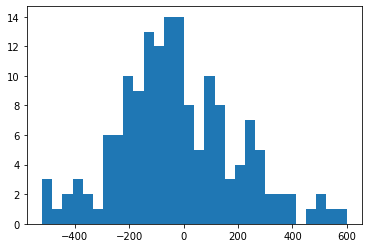

In [85]:
plt.hist(y_test - predictions, bins = 30)

Распределение похоже на нормальное, особого сдвига относительно 0 не наблюдается.

Промежуточный вывод: судя по коэффициенту R2 точность у модели довольно высокая, но судя по анализу остатков - какие-то закономерности остались неучтенными. Надо улучшать модель

# Вторая модель

Обучим вторую модель. Вспомним, что не все связи у нас линейны. Для исправления ситуации преобразуем признаки спо и эке.
Будем учитывать связи входного признака с целевым. Преобразуем СПО в бинарный признак и введем новый признак 'ЭКЕ в квадрате' 

In [86]:
ferma_main_2 = ferma_main.copy(deep=True)
ferma_main_2['СПО (Сахаро-протеиновое соотношение)'] = ferma_main['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_main_2['ЭКЕ (Энергетическая кормовая единица)'] = ferma_main['ЭКЕ (Энергетическая кормовая единица)'].apply(lambda x: pow(x,2))

ferma_main_2 = ferma_main_2.drop(['id', 'Белок,%', 'Жирность,%','Вкус молока'], axis=1)
display(ferma_main_2.head())

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,Возраст
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинные,Соверин,менее_2_лет
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,более_2_лет
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинные,Соверин,менее_2_лет


In [87]:
X = ferma_main_2.drop('Удой, кг', axis=1)
y = ferma_main_2['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

In [88]:
# Разделяем признаки на категориальные и количественные
cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Возраст']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г']

# Кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Собираем выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)



In [89]:
reg_2 = LinearRegression()
reg_2.fit(X_train, y_train)
predictions = reg_2.predict(X_test)

mse_2 = mean_squared_error(y_test, predictions)
rmse_2 = mean_squared_error(y_test, predictions, squared=False)
mae_2 = mean_absolute_error(y_test, predictions)
print(rmse_2)

202.77074442865225


In [90]:
r2_score_2 = r2_score(y_test, predictions)

print(r2_score_2)

0.8172683265328153


(array([ 1.,  0.,  1.,  1.,  0.,  5.,  1.,  2.,  2.,  7.,  8., 13., 10.,
        12., 13., 10., 15.,  9.,  8.,  9.,  6.,  6.,  1.,  3.,  5.,  5.,
         0.,  1.,  0.,  3.]),
 array([-587.78962904, -550.76883161, -513.74803417, -476.72723674,
        -439.70643931, -402.68564187, -365.66484444, -328.644047  ,
        -291.62324957, -254.60245214, -217.5816547 , -180.56085727,
        -143.54005983, -106.5192624 ,  -69.49846497,  -32.47766753,
           4.5431299 ,   41.56392734,   78.58472477,  115.6055222 ,
         152.62631964,  189.64711707,  226.66791451,  263.68871194,
         300.70950937,  337.73030681,  374.75110424,  411.77190168,
         448.79269911,  485.81349654,  522.83429398]),
 <BarContainer object of 30 artists>)

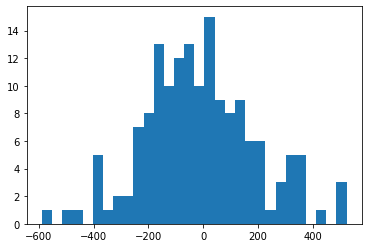

In [91]:
plt.hist(y_test - predictions, bins = 30)

Распределение уже больше походит на нормальное, и r2 вырос по сравнению с первой моделью. Отсюда делаем вывод, что вторая модель точнее

In [92]:
print('95% доверительный интервал =',
      st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))

95% доверительный интервал = (6020.582301955274, 6161.562076914945)


# Третья модель

Теперь третья модель. Добавим новый признак и избавимся от нелинейностей.

In [93]:
ferma_full = ferma_main.merge(ferma_dad, on='id')
ferma_full['СПО (Сахаро-протеиновое соотношение)'] = ferma_full['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_full['ЭКЕ (Энергетическая кормовая единица)'] = ferma_full['ЭКЕ (Энергетическая кормовая единица)'].apply(lambda x: pow(x,2))
ferma_full.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,163.84,2138,0,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,163.84,1675,0,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


In [94]:
ferma_full = ferma_full.drop(['id', 'Белок,%', 'Жирность,%','Вкус молока','порода папы_быка'], axis=1)
ferma_full.head()

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Возраст,Имя Папы
0,5863,201.64,1743,0,Вис Бик Айдиал,Равнинное,более_2_лет,Буйный
1,5529,163.84,2138,0,Вис Бик Айдиал,Равнинные,менее_2_лет,Соловчик
2,5810,196.00,1854,0,РефлешнСоверинг,Холмистое,более_2_лет,Барин
3,5895,153.76,2012,0,РефлешнСоверинг,Холмистое,более_2_лет,Буйный
4,5302,163.84,1675,0,Вис Бик Айдиал,Равнинные,менее_2_лет,Барин


In [95]:
X = ferma_full.drop('Удой, кг', axis=1)
y = ferma_full['Удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
)

In [96]:
X_train_full = pd.concat([X_train, X_test], ignore_index=True)
y_train_full = pd.concat([y_train, y_test], ignore_index=True)

In [97]:
display(X_train_full)

,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Возраст,Имя Папы
0,249.64,1913,1,Вис Бик Айдиал,Холмистое,более_2_лет,Соловчик
1,265.69,2191,1,РефлешнСоверинг,Холмистое,более_2_лет,Барин
2,234.09,2205,1,РефлешнСоверинг,Равнинное,более_2_лет,Буйный
3,249.64,1960,1,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
4,151.29,1929,0,РефлешнСоверинг,Равнинное,менее_2_лет,Барин
...,...,...,...,...,...,...,...
623,219.04,2264,1,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
624,179.56,1742,0,Вис Бик Айдиал,Равнинное,менее_2_лет,Барин
625,182.25,2093,0,РефлешнСоверинг,Равнинные,более_2_лет,Барин
626,268.96,2130,1,РефлешнСоверинг,Холмистое,более_2_лет,Барин


In [98]:
cat_col_names = ['Порода', 'Тип пастбища', 'Возраст', 'Имя Папы']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г']

display(X_train[cat_col_names])

# Кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

# Масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Собираем выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)


,Порода,Тип пастбища,Возраст,Имя Папы
301,Вис Бик Айдиал,Холмистое,более_2_лет,Соловчик
262,РефлешнСоверинг,Холмистое,более_2_лет,Барин
482,РефлешнСоверинг,Равнинное,более_2_лет,Буйный
202,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
255,РефлешнСоверинг,Равнинное,менее_2_лет,Барин
...,...,...,...,...
125,Вис Бик Айдиал,Равнинное,более_2_лет,Барин
401,Вис Бик Айдиал,Равнинное,более_2_лет,Буйный
464,РефлешнСоверинг,Холмистое,более_2_лет,Геркулес
182,Вис Бик Айдиал,Холмистое,более_2_лет,Барин


In [99]:
reg_3 = LinearRegression()
reg_3.fit(X_train, y_train)
predictions = reg_3.predict(X_test)
mse_3 = mean_squared_error(y_test, predictions)
rmse_3 = mean_squared_error(y_test, predictions, squared=False)
mae_3 = mean_absolute_error(y_test, predictions)
print(rmse_3)

199.4221719439715


In [100]:
r2_score_3 = r2_score(y_test, predictions)
print(f'R2_score третьей модели: {r2_score_3}')

R2_score третьей модели: 0.8232537841783365


Проанализируем остатки

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  4.,  3.,  1.,  3.,  5., 10.,
        12., 15., 11., 11., 11., 16., 14.,  5.,  9.,  6.,  3.,  4.,  4.,
         5.,  2.,  0.,  1.]),
 array([-700.32459656, -660.21745652, -620.11031648, -580.00317644,
        -539.8960364 , -499.78889636, -459.68175633, -419.57461629,
        -379.46747625, -339.36033621, -299.25319617, -259.14605613,
        -219.03891609, -178.93177605, -138.82463602,  -98.71749598,
         -58.61035594,  -18.5032159 ,   21.60392414,   61.71106418,
         101.81820422,  141.92534426,  182.03248429,  222.13962433,
         262.24676437,  302.35390441,  342.46104445,  382.56818449,
         422.67532453,  462.78246457,  502.88960461]),
 <BarContainer object of 30 artists>)

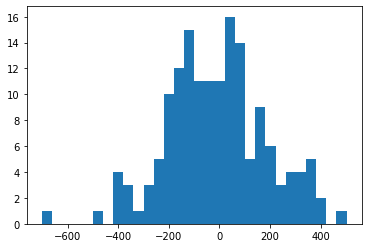

In [101]:
plt.hist(y_test - predictions, bins = 30)

Распределение близко к нормальному, смещения относительно 0 практически нет.

Сравнение трех моделей.

In [102]:
print(mse_1,rmse_1,mae_1)
print(mse_2,rmse_2,mae_2)
print(mse_3,rmse_3,mae_3)

47492.06315234734 217.92673803906519 172.76159571883588
41115.97479614981 202.77074442865225 158.9839573969906
39769.20266285094 199.4221719439715 158.0328933877752


Наилучшие показатели у второй модели. Этот вывод согласуется с показателями r2: 

первая модель - 0.815

вторая модель - 0.826

третья модель - 0.824

95% доверительный интервал у второй модели = (6099.074275449642, 6227.334996154166) (был посчитан заранее)

# Итоговая модель

Теперь воспользуемся лучшей моделью и предскажем удой у коров из cow_buy.

Добавим недостающие признаки.

In [103]:
cow_buy_ml = cow_buy.copy(deep=True)
display(cow_buy.head())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [104]:
display(ferma_main.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [105]:
# Считаем среднее значение каждого недостающего признака и увеличиваем их на 5%
mean_values = ferma_main[['ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)']].mean()
new_values = mean_values * 1.05

In [106]:
display(cow_buy_ml.head())

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [107]:
# Добавляем недостающие признаки в датасет cow_buy и преобразовываем их
cow_buy_ml['ЭКЕ (Энергетическая кормовая единица)'] = new_values['ЭКЕ (Энергетическая кормовая единица)']
cow_buy_ml['ЭКЕ (Энергетическая кормовая единица)'] = cow_buy_ml['ЭКЕ (Энергетическая кормовая единица)'] ** 2
cow_buy_ml['Сырой протеин, г'] = new_values['Сырой протеин, г']
cow_buy_ml['СПО (Сахаро-протеиновое соотношение)'] = new_values['СПО (Сахаро-протеиновое соотношение)']
cow_buy_ml['СПО (Сахаро-протеиновое соотношение)'] = cow_buy_ml['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)

# Форматируем cow_buy
cow_buy_ml = cow_buy_ml.drop(['Текущий_уровень_белок,%'], axis=1)

In [108]:
cow_buy_ml.rename(columns = {'Имя_папы': 'Имя Папы'}, inplace = True)
cow_buy_ml['Тип пастбища'] = cow_buy_ml['Тип пастбища'].replace({'холмистое': 'Холмистое', 'равнинное':'Равнинное'})

# Проверка
display(cow_buy_ml.shape)
display(X_train_full.shape)
display(cow_buy_ml.head())
display(X_train_full.head())

(20, 9)

(628, 7)

,Порода,Тип пастбища,порода папы_быка,Имя Папы,"Текущая_жирность,%",Возраст,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение)
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,более_2_лет,233.361138,2019.947532,1
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,менее_2_лет,233.361138,2019.947532,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,более_2_лет,233.361138,2019.947532,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,более_2_лет,233.361138,2019.947532,1
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,более_2_лет,233.361138,2019.947532,1


,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,Возраст,Имя Папы
0,249.64,1913,1,Вис Бик Айдиал,Холмистое,более_2_лет,Соловчик
1,265.69,2191,1,РефлешнСоверинг,Холмистое,более_2_лет,Барин
2,234.09,2205,1,РефлешнСоверинг,Равнинное,более_2_лет,Буйный
3,249.64,1960,1,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
4,151.29,1929,0,РефлешнСоверинг,Равнинное,менее_2_лет,Барин


In [109]:
display(X_train_full[cat_col_names])

,Порода,Тип пастбища,Возраст,Имя Папы
0,Вис Бик Айдиал,Холмистое,более_2_лет,Соловчик
1,РефлешнСоверинг,Холмистое,более_2_лет,Барин
2,РефлешнСоверинг,Равнинное,более_2_лет,Буйный
3,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
4,РефлешнСоверинг,Равнинное,менее_2_лет,Барин
...,...,...,...,...
623,Вис Бик Айдиал,Холмистое,более_2_лет,Буйный
624,Вис Бик Айдиал,Равнинное,менее_2_лет,Барин
625,РефлешнСоверинг,Равнинные,более_2_лет,Барин
626,РефлешнСоверинг,Холмистое,более_2_лет,Барин


In [110]:
# Разделяем признаки на категориальные и количественные
cat_col_names = ['Порода', 'Тип пастбища', 'Возраст', 'Имя Папы']
num_col_names = ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Сырой протеин, г']

# Кодируем категориальные признаки
X_train_ohe = encoder.transform(X_train_full[cat_col_names])
X_test_ohe = encoder.transform(cow_buy_ml[cat_col_names])
encoder_col_names = encoder.get_feature_names()

In [111]:
# Масштабируем количественные признаки
X_train_scaled = scaler.transform(X_train_full[num_col_names])
X_test_scaled = scaler.transform(cow_buy_ml[num_col_names])

# Собираем выборки 
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)


Обучим модель логистической регрессии.

In [112]:
pred = reg_3.predict(X_test_full)

In [113]:
cow_buy['ожидаемый_удой'] = pred
display(cow_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст,ожидаемый_удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6596.471684
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6318.184019
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6286.377130
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6598.631744
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6547.814085
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6363.147613
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6596.471684
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6524.252258
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6286.377130
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6392.563504


Выводы: мы выбрали лучшую из трех моделей. Это вторая, её показатели:

mse = 34844.95492067928, rmse =  186.66803400871635, mae = 142.6888890194794.

Коэффициент r2 = 0.8288

95% доверительный интервал = (6099.074275449642, 6227.334996154166)


По условию задачи регрессии, можем на данном этапе рекомендовать фермеру для покупки всех коров. Каждая из них, вероятно, выдает более 6000 кг удоя в год, однако еще стоит предсказать, молоко каких коров будет вкусным.

# Задача классфикации

In [114]:
ferma_log = ferma_main.copy(deep=True)
display(ferma_log.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [115]:
# Подготовка признаков
ferma_log['Вкус молока'] = ferma_log['Вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)
ferma_log['СПО (Сахаро-протеиновое соотношение)'] = ferma_log['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)
ferma_log['ЭКЕ (Энергетическая кормовая единица)'] = ferma_log['ЭКЕ (Энергетическая кормовая единица)'] ** 2

ferma_log = ferma_log.drop(['id', 'Удой, кг'], axis=1)

ferma_log.head()

,ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,201.64,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1,более_2_лет
1,163.84,2138,0,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,1,менее_2_лет
2,196.00,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0,более_2_лет
3,153.76,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0,более_2_лет
4,163.84,1675,0,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,1,менее_2_лет


In [116]:
X = ferma_log.drop('Вкус молока', axis=1)
y = ferma_log['Вкус молока']

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

# Заранее создадим объединенную тренировочную выборку
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

cat_col_names = ['Порода', 'Тип пастбища', 'порода папы_быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)']
num_col_names = ['Жирность,%', 'Белок,%', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_valid_ohe = encoder.transform(X_valid[cat_col_names])
encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_valid_scaled = scaler.transform(X_valid[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)


In [117]:
# Обучение модели
clf = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

clf_accuracy = accuracy_score(y_pred, y_valid)
clf_recall = recall_score(y_pred, y_valid)
clf_precision = precision_score(y_pred, y_valid)

print(f'Accuracy: {clf_accuracy}')
print(f'Recall: {clf_recall}')
print(f'Precision: {clf_precision}')
print('---')


Accuracy: 0.6114649681528662
Recall: 0.6422018348623854
Precision: 0.7608695652173914
---


Text(0.5, 15.0, 'Predicted')

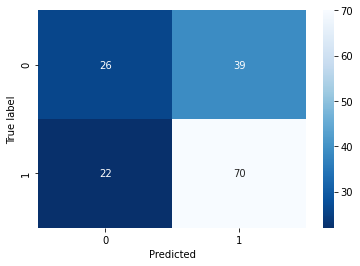

In [118]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

Более критична здесь ошибка первого рода: объявить невкусное молоко вкусным. 

In [119]:
y_proba = clf.predict_proba(X_valid)[:, 1]

proba_data = pd.DataFrame(zip(y_valid, y_proba),
                          columns=['y_valid', 'y_proba']).sort_values(by='y_proba', ascending=False)

proba_data.head()

,y_valid,y_proba
97,1,0.910512
7,1,0.886514
47,1,0.881913
17,1,0.859027
62,1,0.857730


In [120]:
# Функция расчета метрик для каждого порога
def threshold_choice(threshold_list, proba_df):
    result_df = pd.DataFrame(columns=['порог', 'precision', 'recall', 'количество_FP', 'число_предсказанных_объектов',
                                      'всего_объектов_класса_1'])

    for threshold in threshold_list:
        column_name = 'y_pred_' + str(threshold)

        # Precision
        precision = proba_df.loc[proba_df[column_name] == 1, 'y_valid'].mean()

        # Число предсказанных объектов
        predicted_objects = proba_df[column_name].sum()

        # Всего объектов класса 1
        total_objects_class_1 = proba_df['y_valid'].sum()

        # Recall
        recall = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_valid'] == 1)].shape[
                     0] / total_objects_class_1

        # Количество ложноположительных предсказаний (FP)
        false_positives = proba_df.loc[(proba_df[column_name] == 1) & (proba_df['y_valid'] == 0)].shape[0]

        # Добавляем результаты в датафрейм
        result_df = result_df.append({
            'порог': threshold,
            'precision': precision,
            'recall': recall,
            'количество_FP': false_positives,
            'число_предсказанных_объектов': predicted_objects,
            'всего_объектов_класса_1': total_objects_class_1,
        }, ignore_index=True)

    return result_df


In [121]:
proba_data_1 = proba_data.copy(deep=True)

thresholds_1 = [round(i, 2) for i in np.linspace(0.1, 1, num=10, endpoint=False)]
columns = []

for i in thresholds_1:
    columns.append('y_pred_' + str(i))
    proba_data_1['y_pred_' + str(i)] = proba_data_1['y_proba'].apply(lambda x: 1 if x > i else 0)

proba_data_1.head(5)

,y_valid,y_proba,y_pred_0.1,y_pred_0.19,y_pred_0.28,y_pred_0.37,y_pred_0.46,y_pred_0.55,y_pred_0.64,y_pred_0.73,y_pred_0.82,y_pred_0.91
97,1,0.910512,1,1,1,1,1,1,1,1,1,1
7,1,0.886514,1,1,1,1,1,1,1,1,1,0
47,1,0.881913,1,1,1,1,1,1,1,1,1,0
17,1,0.859027,1,1,1,1,1,1,1,1,1,0
62,1,0.857730,1,1,1,1,1,1,1,1,1,0


In [122]:
threshold_choice(thresholds_1, proba_data_1)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.10,0.585987,1.000000,65.0,157.0,92.0
1,0.19,0.585987,1.000000,65.0,157.0,92.0
2,0.28,0.593333,0.967391,61.0,150.0,92.0
3,0.37,0.602837,0.923913,56.0,141.0,92.0
4,0.46,0.625000,0.815217,45.0,120.0,92.0
5,0.55,0.639535,0.597826,31.0,86.0,92.0
6,0.64,0.661017,0.423913,20.0,59.0,92.0
7,0.73,0.636364,0.228261,12.0,33.0,92.0
8,0.82,0.800000,0.086957,2.0,10.0,92.0
9,0.91,1.000000,0.010870,0.0,1.0,92.0


In [123]:
proba_data_2 = proba_data.copy(deep=True)

thresholds_2 = [round(i, 2) for i in np.linspace(0.64, 0.85, num=11, endpoint=False)]

columns = []

for i in thresholds_2:
    columns.append('y_pred_' + str(i))
    proba_data_2['y_pred_' + str(i)] = proba_data_2['y_proba'].apply(lambda x: 1 if x > i else 0)

proba_data_2.head(5)

,y_valid,y_proba,y_pred_0.64,y_pred_0.66,y_pred_0.68,y_pred_0.7,y_pred_0.72,y_pred_0.74,y_pred_0.75,y_pred_0.77,y_pred_0.79,y_pred_0.81,y_pred_0.83
97,1,0.910512,1,1,1,1,1,1,1,1,1,1,1
7,1,0.886514,1,1,1,1,1,1,1,1,1,1,1
47,1,0.881913,1,1,1,1,1,1,1,1,1,1,1
17,1,0.859027,1,1,1,1,1,1,1,1,1,1,1
62,1,0.857730,1,1,1,1,1,1,1,1,1,1,1


In [124]:
threshold_choice(thresholds_2, proba_data_2)

,порог,precision,recall,количество_FP,число_предсказанных_объектов,всего_объектов_класса_1
0,0.64,0.661017,0.423913,20.0,59.0,92.0
1,0.66,0.673469,0.358696,16.0,49.0,92.0
2,0.68,0.642857,0.293478,15.0,42.0,92.0
3,0.70,0.634146,0.282609,15.0,41.0,92.0
4,0.72,0.647059,0.239130,12.0,34.0,92.0
5,0.74,0.666667,0.217391,10.0,30.0,92.0
6,0.75,0.703704,0.206522,8.0,27.0,92.0
7,0.77,0.650000,0.141304,7.0,20.0,92.0
8,0.79,0.733333,0.119565,4.0,15.0,92.0
9,0.81,0.800000,0.086957,2.0,10.0,92.0


Возьмем пороговым значением 0.8

In [125]:
# Выделяем оптимальный порог
OPTIMAL_THRESHOLD = 0.8

# Применение порога к предсказанным вероятностям
y_pred_threshold = (y_proba > OPTIMAL_THRESHOLD).astype(int)

clf_accuracy_new = accuracy_score(y_valid, y_pred_threshold)
clf_recall_new = recall_score(y_valid, y_pred_threshold)
clf_precision_new = precision_score(y_valid, y_pred_threshold)

print(f'Old Accuracy: {clf_accuracy}')
print(f'Old Recall: {clf_recall}')
print(f'Old Precision: {clf_precision}')
print('---')
print(f'New Accuracy: {clf_accuracy_new}')
print(f'New Recall: {clf_recall_new}')
print(f'New Precision: {clf_precision_new}')
print('---')

Old Accuracy: 0.6114649681528662
Old Recall: 0.6422018348623854
Old Precision: 0.7608695652173914
---
New Accuracy: 0.45222929936305734
New Recall: 0.10869565217391304
New Precision: 0.7142857142857143
---


Text(0.5, 15.0, 'Predicted')

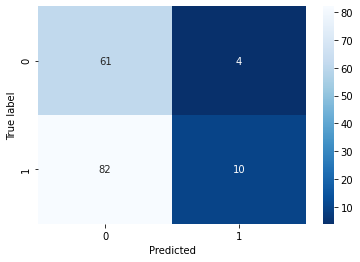

In [126]:
cm_new = confusion_matrix(y_valid, y_pred_threshold)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')

Мы снизили количество ложно положительных ответов с 39 до 0, что и требовалось в тз.

Теперь спрогнозируем вкус молока.

In [127]:
cow_buy_ml_2 = cow_buy.copy(deep=True)

In [128]:
print(new_values)

ЭКЕ (Энергетическая кормовая единица)      15.276162
Сырой протеин, г                         2019.947532
СПО (Сахаро-протеиновое соотношение)        0.958744
dtype: float64


In [129]:
print(cow_buy_ml_2.columns)

Index(['Порода', 'Тип пастбища', 'порода папы_быка', 'Имя_папы',
       'Текущая_жирность,%', 'Текущий_уровень_белок,%', 'Возраст',
       'ожидаемый_удой'],
      dtype='object')


In [130]:
cow_buy_ml_2['ЭКЕ (Энергетическая кормовая единица)'] = new_values['ЭКЕ (Энергетическая кормовая единица)']
cow_buy_ml_2['ЭКЕ (Энергетическая кормовая единица)'] = cow_buy_ml_2['ЭКЕ (Энергетическая кормовая единица)'] ** 2
cow_buy_ml_2['Сырой_протеин, г'] = new_values['Сырой протеин, г']
cow_buy_ml_2['СПО (Сахаро-протеиновое соотношение)'] = new_values['СПО (Сахаро-протеиновое соотношение)']
cow_buy_ml_2['СПО (Сахаро-протеиновое соотношение)'] = cow_buy_ml_2['СПО (Сахаро-протеиновое соотношение)'].apply(lambda x: 1 if x > 0.91 else 0)

# Форматируем cow_buy
cow_buy_ml_2.rename(columns={'Текущая_жирность,%': 'Жирность,%', 'Текущий_уровень_белок,%': 'Белок,%'}, inplace=True)
cow_buy_ml_2 = cow_buy_ml_2.drop(['Имя_папы'], axis=1)

# Подготовка признаков
cow_buy_ml_2['Тип пастбища'] = cow_buy_ml_2['Тип пастбища'].replace({'холмистое': 'Холмистое', 'равнинное':'Равнинное'})
cow_buy_ml_2.head()

,Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Возраст,ожидаемый_удой,ЭКЕ (Энергетическая кормовая единица),"Сырой_протеин, г",СПО (Сахаро-протеиновое соотношение)
0,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,6596.471684,233.361138,2019.947532,1
1,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,6318.184019,233.361138,2019.947532,1
2,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,6286.377130,233.361138,2019.947532,1
3,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,6598.631744,233.361138,2019.947532,1
4,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,6547.814085,233.361138,2019.947532,1


In [131]:
X_train_full.rename(columns={'Сырой протеин, г':'Сырой_протеин, г'}, inplace=True)
display(X_train_full.head())

,ЭКЕ (Энергетическая кормовая единица),"Сырой_протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Возраст
0,216.09,1795,0,Вис Бик Айдиал,Равнинные,Айдиалл,3.61,3.082,более_2_лет
1,213.16,1794,0,Вис Бик Айдиал,Холмистое,Соверин,3.59,3.077,более_2_лет
2,158.76,1784,0,РефлешнСоверинг,Холмистое,Соверин,3.21,3.077,менее_2_лет
3,265.69,2191,1,РефлешнСоверинг,Холмистое,Соверин,3.72,3.078,более_2_лет
4,222.01,1849,0,Вис Бик Айдиал,Равнинное,Айдиалл,3.48,3.073,более_2_лет


In [132]:
cat_col_names = ['Порода','Тип пастбища', 'порода папы_быка', 'Возраст', 'СПО (Сахаро-протеиновое соотношение)']
num_col_names = ['Жирность,%', 'Белок,%', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой_протеин, г']

X_train_ohe = encoder.transform(X_train_full[cat_col_names])
X_test_ohe = encoder.transform(cow_buy_ml_2[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_scaled = scaler.transform(X_train_full[num_col_names])
X_test_scaled = scaler.transform(cow_buy_ml_2[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train_full = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_full = pd.concat([X_test_ohe, X_test_scaled], axis=1)



In [133]:
y_proba = clf.predict_proba(X_test_full)[:, 1]
predictions_final = (y_proba > OPTIMAL_THRESHOLD).astype(int)

In [134]:
cow_buy['ожидаемый_вкус_молока'] = predictions_final
cow_buy['ожидаемый_вкус_молока'] = cow_buy['ожидаемый_вкус_молока'].apply(lambda x: 'вкусно' if x == 1 else 'не вкусно')
to_buy = cow_buy.query('ожидаемый_вкус_молока == "вкусно"')
cow_buy


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст,ожидаемый_удой,ожидаемый_вкус_молока
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6596.471684,не вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6318.184019,не вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6286.377130,не вкусно
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6598.631744,не вкусно
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6547.814085,не вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6363.147613,не вкусно
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6596.471684,не вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6524.252258,не вкусно
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6286.377130,не вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6392.563504,не вкусно


Таким образом, коров выбранных моделью как коровы с потенциально вкусным молоком нет. 

In [135]:
display(to_buy)

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст,ожидаемый_удой,ожидаемый_вкус_молока


## Итоговые выводы

В ходе работы были разработаны модели, позволяющие отбирать коров в удоем более 6000 кг/год и вкусным молоком. Отобранных коров нет

Что было сделано в работе:

1) Импортированы все необходимые для работы библиотеки 

2) Загружены три датасета: ferma_main, ferma_dad, cow_buy. В ferma_main содержится информация о стаде фермера на текущий момент. В ferma_dad - имя папы каждой коровы в стаде фермера. Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

Данные были приведены в порядок, разделены слипшиеся столбцы.

3) Была проведена предобработка данных. Удалены дубликаты, изменены типы данных. Была проверка на пропуски, их обнаружено не было. Некоторые количественные данные были приведены в "адекватность". Например, белок: c 3074% до 3.074%

3) Выполнен исследовательский анализ данных. Проведен статистический анализ всех признаков и построены графики.
В распределение категориальных переменных критических изменений внесено не было

4)  Корреляционный анализ данных

эке: Выявили положительную взаимосвязь выше умеренного значения. С увеличением "удоя" постепенно увеличивается и эке. По графикам распределения, корреляция справедлива для двух пород.

сырой_протеин: Взаимосвязь между содержанием сырого протеина и удоем не так ясна. На графике диаграмме рассеяния виден довольно большой разброс значений, однако наблюдается общий тренд на прямую пропорциональную зависимость. Связь умеренно положительная.

спо: Выявили, что СПО зависит от целевого признака - коэффициент корреляции выше среднего. В особенности видна резкая тенденция возвышения значений после - определен "порог перехода" в значении спо = 0.91
 жирность: Выявлена умеренно положительная зависимость. Более всего связь раскрывается на переходе значений жирность = 3.6 и 3.7.
белок: Связь между этим признаком и целевым - нелинейная.

возраст имеет сильнейшую взаимосвязь с целевым признаком удой.

Между целевым и входными признаками связь в основном линейная, но наличие нелинейных связей также возможно для отдельных пород. Яркие нелинейные связи не выявлены, в связи с чем добавление новых признаков - не потребовалось
Что касается мультиколлинеарности: матрица показала, что между некоторыми входными признаками есть умеренная корреляция, но нет явных признаков сильной мультиколлинеарности, с которой стоило бы справляться.

5) Задача регрессии. Предсказывали признак 'удой кг'. Обучили три модели линейной регресии: 

1. чисто по линейной связи между признаками
2. по линейной связи между признаками, но между спо и удоем устранена нелинейность: спо был сделан категориальным признаком
3. был добавлен признак 'имя_папы', остальное как в пункте 2.

Наиболее эффективна по метрикам и анализу остатков модель номер 2. Ей и воспользовались, чтобы предсказать удой. По результам модель предсказала, что все коровы из cow_buy дают необходимый удой (> 6000 кг/год)

6) Подобрали параметры и обучили модель логистической регрессии. Проанализировали модель и минимизировали количество критических ошибок первого рода с 39 до 0, подобрав новый порог для вероятности предсказаний.
Полученная модель не отобрала коров с потенциально вкусным молоком. 
